# Filter sea-level data

Filter the sea-level time series from the stations before Ciutadella.<br>
Input: list of dates for different rissaga events.

In [207]:
rissagadates = ((2016, 2, 7, 11, 13, 0), )

In [218]:
dayrissaga = datetime.datetime(events[0], events[1],events[2], events[3], events[4],events[5])

In [208]:
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
import datetime, time, calendar
import matplotlib.text as text
import matplotlib as mpl
from scipy import signal
from matplotlib import dates
%matplotlib inline

## Configuration

Making the text bigger and the default color for lines black.

In [209]:
mpl.rcParams.update({'font.size': 20})
mpl.rcParams['lines.color'] = 'k'

Setting the format for the dates (day and month)

In [210]:
hfmt = dates.DateFormatter('%d %B')

## List of file to process

Should be obtained using [Data Discovery](http://appstest.socib.es/DataDiscovery/index.jsp).

In [211]:
filelist = []
for events in rissagadates:
    dayrissaga = datetime.datetime(events[0], events[1],events[2])
    daybefore = dayrissaga - datetime.timedelta(days=3)
    dayafter = dayrissaga + datetime.timedelta(days=3)
    year = str(events[0])
    month = str(events[1]).zfill(2)
    day = str(events[2]).zfill(2)
    print year, month, day
    filelist.append((
    "http://thredds.socib.es/thredds/dodsC/mooring/sea_level/"
    "station_sarapita/L1/%s/dep20110505_station-sarapita_L1_%s-%s.nc" 
    %(str(daybefore.year), str(daybefore.year), str(daybefore.month).zfill(2))
    ))
    filelist.append((
    "http://thredds.socib.es/thredds/dodsC/mooring/sea_level/"
    "station_sarapita/L1/%s/dep20110505_station-sarapita_L1_%s-%s.nc" 
    %(str(dayafter.year), str(dayafter.year), str(dayafter.month).zfill(2))
    ))
    filelist = list(set(filelist))
    print filelist

2016 02 07
['http://thredds.socib.es/thredds/dodsC/mooring/sea_level/station_sarapita/L1/2016/dep20110505_station-sarapita_L1_2016-02.nc']


# Data access

We will use [OPeNDAP](http://www.opendap.org/) protocol do extract the data from the netCDF file.<br>
We load all the data (2 months max.), then we select the good time. 

In [212]:
pressure_time, pressure = np.array([]), np.array([])
for file2load in filelist:
    print("Working on %s" %(file2load))
    with netCDF4.Dataset(file2load) as nc:
        time_units = nc.variables['time'].units
        pressure_units = nc.variables['WTR_PRE'].units
        pressure_time = np.append(pressure_time, nc.variables['time'][:])
        pressure = np.append(pressure, nc.variables['WTR_PRE'][:])

Working on http://thredds.socib.es/thredds/dodsC/mooring/sea_level/station_sarapita/L1/2016/dep20110505_station-sarapita_L1_2016-02.nc


## Selection of good time period

In [213]:
tmin = (daybefore - datetime.datetime(1970,1,1)).total_seconds()
tmax = (dayafter - datetime.datetime(1970,1,1)).total_seconds()
goodtime = np.where((pressure_time >= tmin) & (pressure_time <= tmax))[0]

# Plotting

Consider only the dates of interest

In [214]:
pressure_time = pressure_time[goodtime]
pressure = pressure[goodtime]

Change the date format

In [215]:
time2plot = netCDF4.num2date(pressure_time, time_units)
print time2plot[0], time2plot[-1]
print dayrissaga

2016-02-04 00:00:00 2016-02-10 00:00:00
2016-02-07 00:00:00


Now we can make a very simple plot to show the evolution of the pressure at 6 m depth.

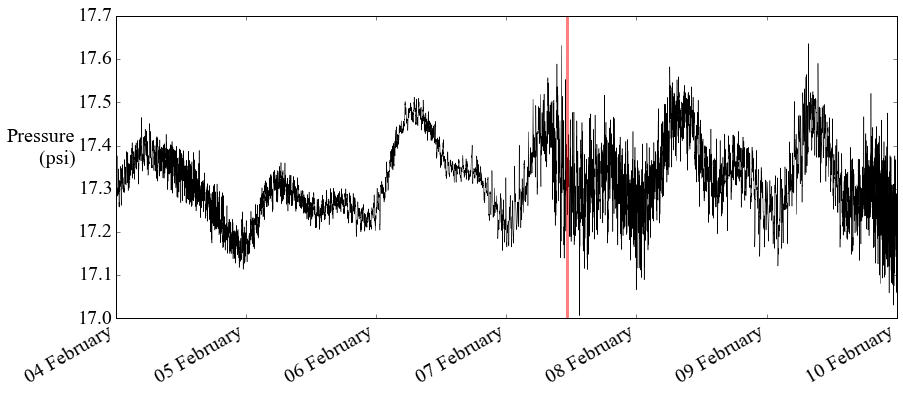

In [219]:
fig = plt.figure(num=None, figsize=(14, 6))
ax = fig.add_subplot(111) 
plt.plot(time2plot, pressure, 'k', lw=0.5)
plt.ylabel(("Pressure\n (%s)" %(pressure_units)), ha='right', rotation=0)
plt.axvline(x=dayrissaga, linewidth=3, color='r', alpha=0.5)
ax.xaxis.set_major_locator(dates.DayLocator())
ax.xaxis.set_major_formatter(hfmt)
fig.autofmt_xdate()

# Filtering

Now we want to apply a low-pass filter on the signal. For this, we will use the signal module available in scipy.
For the filter, it is necessary to set:
    <ul>
        <li> the cutoff frequency, </li>
        <li> the filter length, </li>
        <li> the window applied to the filter. </li>
    </ul>

## Filter design

In [193]:
N1=128                       # filter length 
windowsname = 'blackman'    # windows name
sample_rate = 1/60.0                # one data per minute
nyq_rate = sample_rate / 2.0        # Nyquist rate
frqcut = 1.0/(36*3600.)             # cutoff frequency
cutoff = frqcut/nyq_rate            # Cutoff relative to Nyquist rate

## Filter creation and application

In [194]:
taps1 = signal.firwin(N1, cutoff=cutoff, window=(windowsname))  
pressure_filtered = signal.lfilter(taps1, 1.0, pressure)
delay = 0.5 * (N1-1) / sample_rate

In [195]:
time2plot_filter = netCDF4.num2date(pressure_time - delay, time_units)

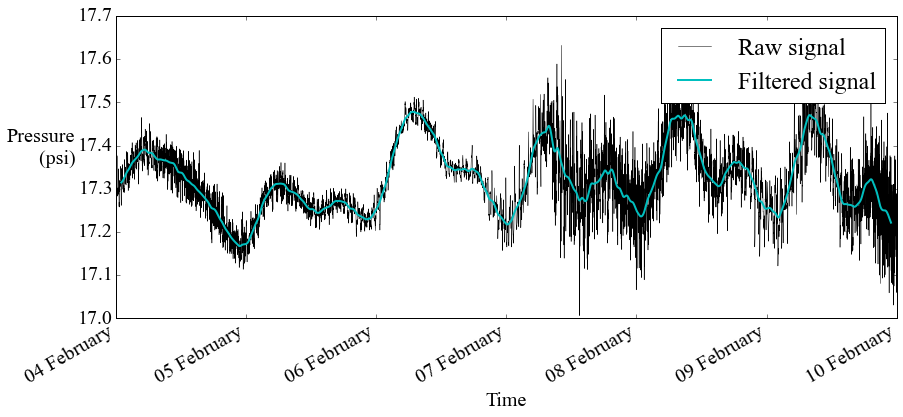

In [196]:
fig = plt.figure(num=None, figsize=(14, 6))
ax = fig.add_subplot(111) 
plt.plot(time2plot, pressure, 'k', lw=0.5, label='Raw signal')
plt.plot(time2plot_filter[N1:], pressure_filtered[N1:], 'c', linewidth=2, zorder=2, label='Filtered signal')
plt.xlabel('Time')
plt.ylabel(("Pressure\n (%s)" %(pressure_units)), ha='right', rotation=0)
plt.legend()
ax.xaxis.set_major_locator(dates.DayLocator())
ax.xaxis.set_major_formatter(hfmt)
fig.autofmt_xdate()
plt.show()

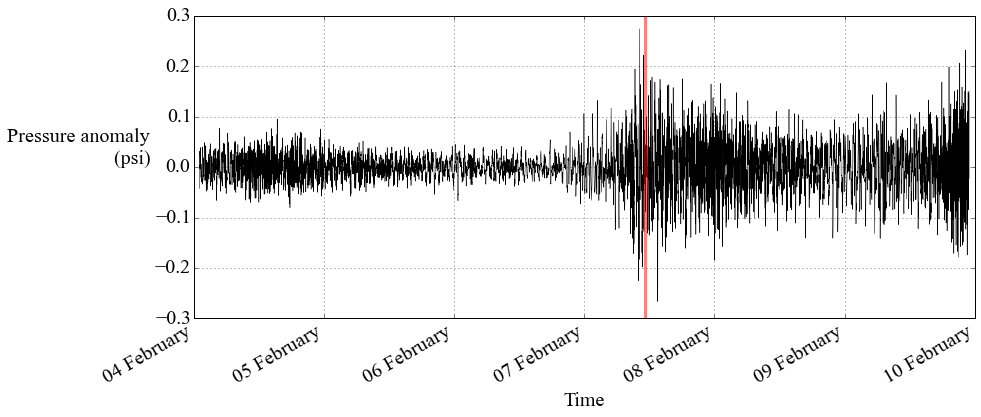

In [221]:
fig = plt.figure(num=None, figsize=(14, 6))
ax = fig.add_subplot(111) 
plt.plot(time2plot[N1/2:-N1/2], pressure[N1/2:-N1/2] - pressure_filtered[N1:], 'k', lw=0.5)
plt.xlabel('Time')
plt.ylabel(("Pressure anomaly\n (%s)" %(pressure_units)), ha='right', rotation=0)
plt.axvline(x=dayrissaga, linewidth=3, color='r', alpha=0.5)
ax.set_xlim(time2plot[0],time2plot[-1])
ax.xaxis.set_major_locator(dates.DayLocator())
ax.xaxis.set_major_formatter(hfmt)
fig.autofmt_xdate()
plt.grid()
plt.show()

In [223]:
dayrissaga.strftime('%Y%m%d') 

'20160207'